In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

In [2]:
import textgrids

FRAME_DURATION = 30 # 30 msec
OVERLAP_RATE = 0 # frames don't overlap

def readFile(path):
    '''
    Read the file and return the list of SPEECH/NONSPEECH labels for each frame
    '''
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        if interval.text == "-" or interval.text == " ":
            label = 0
        else:
            label = 1
        dur = interval.dur
        dur_msec = dur * 1000 # sec -> msec
        num_frames = int(round(dur_msec /30)) # the audio is divided into 30 msec frames
        print(dur_msec)
        for i in range(num_frames):
            
            labeled_list.append(label)

    return labeled_list

In [3]:
# Function for reading labels from .TextGrig file:
def readLabels(path, sample_rate):
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        if interval.text == "-" or interval.text == " ":
            label = 0
        else:
            label = 1

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples
        
        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

In [4]:
import os
import librosa

# root = 'Female/TMIT/SA2'
# audio_name = 'FF482278-24C9-4FB0-A7BE-FD92D1FE17B4-1430028319-1.0-m-26-hu.wav'
# annotation_name = 'FF482278-24C9-4FB0-A7BE-FD92D1FE17B4-1430028319-1_0-m-26-hu.TextGrid'
# audio_path = os.path.join('/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/hungry', audio_name)
# annotation_path = os.path.join('/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/hungry', annotation_name)

annotation_path = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations/0c8f14a9-6999-485b-97a2-913c1cbf099c-1430760379259-1.7-m-26-hu.wav.TextGrid"
audio_path = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/no_subdirectories/0c8f14a9-6999-485b-97a2-913c1cbf099c-1430760379259-1.7-m-26-hu.wav"

# Read annotation
label_list = readFile(annotation_path)
# Read wav file
data, fs = librosa.load(audio_path)

538.0000000000002
215.99999999999997
392.0000000000001
559.9999999999999
2432.0910949540526
1759.3065500456717
1042.6023550002758


In [5]:
# define time axis
Ns = len(data)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * 1000 * Ts  # time axis


shift = 1 - OVERLAP_RATE
frame_length = int(np.floor(FRAME_DURATION * fs / 1000)) # frame length in sample
frame_shift = round(frame_length * shift) # frame shift in sample

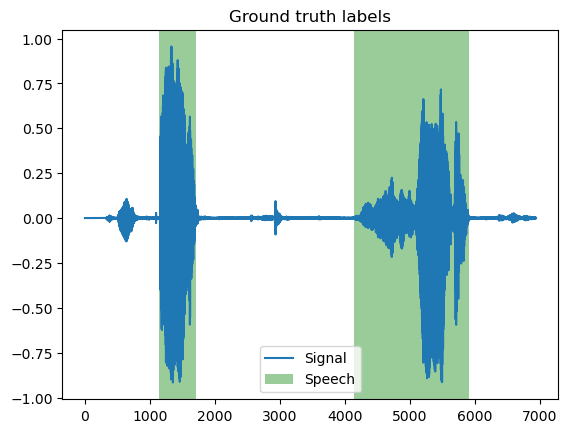

In [6]:
import matplotlib.pyplot as plt

figure = plt.Figure(figsize=(10, 7), dpi=85)
plt.plot(t, data)

for i, frame_labeled in enumerate(label_list):
    idx = i * frame_shift
    if (frame_labeled == 1):
        plt.axvspan(xmin= t[idx], xmax=t[idx + frame_length-1], ymin=-1000, ymax=1000, alpha=0.4, zorder=-100, facecolor='g', label='Speech')

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech'])
plt.show()

In [7]:
# Preparation
import python_speech_features
from tqdm import tqdm 
from sklearn import model_selection, preprocessing, metrics
# from keras.models import Model
# import keras.layers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [8]:
# Function for getting all files in directories and sub-directories woth definite extension
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths

In [13]:
annotation_path = '/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations'
annotation_extension = '.TextGrid'
audio_path = '/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_textgrids'
audio_extension = '.wav'

annotation_files = getFiles(path=annotation_path, extension=annotation_extension)
audio_files = getFiles(path=audio_path, extension=audio_extension)
annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

In [14]:
# Processing files

# Set params for Mel-Frequency Cepstral Coefficient (MFCC)
# preemphasis_coef (Pre-emphasis coefficient): The coefficient is used in a preemphasis filter applied to the audio signal before further processing. A value close o 1 emphasis higher frequencies, compensating for the natural roll-off of high frequencies in audio signals
# frame_length: The length of time each window will be when the signal is segmented into frames. (Normally ranged between 20 to 30 milliseconds)
# fram_step: The time window shifted between frames.
# window_function: Applied to each frame to reduce spectral leakage from outside the frame. Hamming window is commonly used
# num_nfft (Number of points for FFT): The number of points used in the Fast Fourier Transform when converting each frame from the time domain to the frequency domain. Large FFT size allow for more precise frequency resolution but also increased computation time.
# num_features (Number of Mel filters): The number of Mel-frequency bins used in the MFCC.

# Mel scale is a way of representing frequencies in a manner similar to human perception. By using Mel filters, the features capture the psychoacoustic properties of the sound.

preemphasis_coef = 0.97 
frame_length = 0.025 
frame_step = 0.01
window_function = np.hamming
num_nfft = 551 
num_features = 32 

In [15]:
len(audio_files)

0

In [16]:
import librosa

# Extraction features for each file:
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)

    # Extract features:
    # features_fbank (Mel-frequency cepstral coefficiens): captures the spectral information of the audio signal in a way that mimics human auditory perception
    # feature_energy: the overall energy of the audio signal within a specific frequency range
    features_fbank, feature_energy  = python_speech_features.base.fbank(signal=sig, 
                                                                        samplerate=sample_rate, 
                                                                        winlen=frame_length, 
                                                                        winstep=frame_step, 
                                                                        nfilt=num_features, 
                                                                        nfft=num_nfft, 
                                                                        lowfreq=0, 
                                                                        highfreq=None, 
                                                                        preemph=preemphasis_coef, 
                                                                        winfunc=window_function)
    # Logfbank and log energy:
    features_logfbank = np.log(features_fbank)
    feature_logenergy = np.log(feature_energy)
    # print('Shape logfbank:', features_fbank.shape)
    # print('Shape logenergy:', feature_logenergy.shape)

    # Merge logfbank and log energy:
    features = np.hstack((feature_logenergy.reshape(feature_logenergy.shape[0], 1), features_logfbank))
    # print('Shape features:', features.shape)

    # Reshape labels for each group of features:
    markers_of_frames = python_speech_features.sigproc.framesig(sig=markers, 
                                                                frame_len=frame_length * sample_rate, 
                                                                frame_step=frame_step * sample_rate, 
                                                                winfunc=np.ones)
    # print('Shape markers_of_frame:', markers_of_frames.shape)
    # For every frame calc label:
    # For every frame calc label:
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])

    # Create massive for stacking features in first step:
    if i == 0:
        dataset_tmp = np.zeros((1, num_features + 2))

    # Check indices of features and labels:
    restrictive_index = np.min([features.shape[0], marker_per_frame.shape[0]], axis=0)
    features_tmp = features[:restrictive_index]
    marker_per_frame_tmp = marker_per_frame[:restrictive_index]
    
    # Merge label and franes and all frames in dataset:
    dataset_tmp = np.vstack((dataset_tmp, np.hstack((marker_per_frame_tmp.reshape(marker_per_frame_tmp.shape[0], 1), features_tmp))))

0it [00:00, ?it/s]


In [17]:
# Delete row consist of zeros:
dataset = dataset_tmp[1:]

NameError: name 'dataset_tmp' is not defined

In [ ]:
# Preparation of data
# Split dataset on train and test:
X = dataset[:, 1:]
y = dataset[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape datasets to 1 x 300 x num_features:
# So, each group need to consist of 300 frames:
n_frames = 300
X_train_reshaped = X_train[:int(X_train.shape[0] / n_frames) * n_frames]
X_train_reshaped = X_train_reshaped.reshape(int(X_train_reshaped.shape[0] / n_frames), n_frames, X_train_reshaped.shape[1])
X_test_reshaped = X_test[:int(X_test.shape[0] / n_frames) * n_frames]
X_test_reshaped = X_test_reshaped.reshape(int(X_test_reshaped.shape[0] / n_frames), n_frames, X_test_reshaped.shape[1])



(1347099, 33) (663498, 33) (1347099,) (663498,)


In [ ]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_reshaped = y_train[:int(y_train.shape[0] / n_frames) * n_frames]
y_train_reshaped = y_train_reshaped.reshape(int(y_train_reshaped.shape[0] / n_frames), n_frames, y_train_reshaped.shape[1])
y_test_reshaped = y_test[:int(y_test.shape[0] / n_frames) * n_frames]
y_test_reshaped = y_test_reshaped.reshape(int(y_test_reshaped.shape[0] / n_frames), n_frames, y_test_reshaped.shape[1])

In [ ]:
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_reshaped, dtype=torch.float32)

print(X_train_tensor.shape)

# Combine features and labels into a TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([4490, 300, 33])


In [ ]:
X_train_reshaped.shape

(4490, 300, 33)

In [ ]:
y_train_reshaped.shape

(4490, 300, 2)

In [ ]:
# Transformer model

# Define the cosine decay parameters
initial_learning_rate = 0.01
decay_steps = 10000

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, n_heads=2, hidden_dim=64, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        
        # Permute dimensions for Transformer input
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, hidden_dim)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Permute dimensions back
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, hidden_dim)
        
        # Apply final linear layer
        x = self.fc(x)
        
        return x

In [ ]:
import pickle

with open('attention_variables.pkl', 'wb') as f:
    pickle.dump(y_train_reshaped, f)
    pickle.dump(X_train_reshaped, f)

In [ ]:
with open("/home/benjamin.lambright/Desktop/ugrip/Dannings_code/attention_variables.pkl", 'rb') as f:
    y_train_reshaped = pickle.load(f)
    X_train_reshaped = pickle.load(f)

In [ ]:
device

device(type='cuda')

In [ ]:
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Define input and output dimensions
input_dim = 33
output_dim = 2

# Initialize model
model = TransformerModel(input_dim=input_dim, output_dim=output_dim).to(device)

# Define input and output data
# target_tensor = torch.tensor(y_train_reshaped, dtype=torch.float).to(device)
# query_input_tensor = torch.tensor(X_train_reshaped, dtype=torch.long).to(device)
# input_data = torch.randn(587, 300, input_dim)

# loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# define cosine decay
T_0 = 10  # Initial number of epochs for the first restart
T_mult = 2  # Multiplicative factor by which the number of epochs for every subsequent restarts increases
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)

# epoch num
num_epochs = 50

# savin metrics so we can plot them
history = {'loss': [], 'accuracy': []}

for epoch in range(num_epochs):
    
    for query_input_tensor, target_tensor in train_loader:
        query_input_tensor = query_input_tensor.to(device)
        # print(query_input_tensor.shape)
        target_tensor = target_tensor.to(device)
        # print(target_tensor.shape)

        # Forward pass
        output = model(query_input_tensor)

        # Compute the loss
        loss = criterion(output, target_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the learning rate
        scheduler.step()

        # Print loss for monitoring
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Optionally, calculate and print accuracy
        with torch.no_grad():
            predicted_labels = torch.argmax(output, dim=-1)
            target_labels = torch.argmax(target_tensor, dim=-1)
            accuracy = accuracy_score(target_labels.view(-1).cpu().numpy(), predicted_labels.view(-1).cpu().numpy())
            print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}')
        
        # save these metrics so we can plot them
        history['loss'].append(loss.item())
        history['accuracy'].append(accuracy)


/home/benjamin.lambright/.conda/envs/ugrip/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.6876
Epoch [1/50], Accuracy: 0.6724
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.3168
Epoch [1/50], Accuracy: 0.9161
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.3162
Epoch [1/50], Accuracy: 0.9128
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2985
Epoch [1/50], Accuracy: 0.9157
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2851
Epoch [1/50], Accuracy: 0.9189
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2917
Epoch [1/50], Accuracy: 0.9151
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2886
Epoch [1/50], Accuracy: 0.9159
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2893
Epoch [1/50], Accuracy: 0.9155
torch.Size([64, 300, 33])
torch.Size([64, 300, 2])
Epoch [1/50], Loss: 0.2890
Epoch [1/50], Accuracy: 0.9156
torch.Size([64, 300

In [ ]:
# saving the model

torch.save(model.state_dict(), 'transformer.pt')

# if I want to load it up again
# model.load_state_dict(torch.load('transformer.pt'))

In [ ]:
from sklearn.metrics import confusion_matrix

# getting the labels in order to compute the confusion matrix
predicted_labels = torch.argmax(output, dim=-1)
target_labels = torch.argmax(target_tensor, dim=-1)

# making these labels numpy arrays
numpy_target_labels = target_labels.view(-1).cpu().numpy()
numpy_predicted_labels = predicted_labels.view(-1).cpu().numpy()

conf_matrix = confusion_matrix(numpy_target_labels, numpy_predicted_labels)
conf_matrix

array([[2762,    0],
       [ 238,    0]])

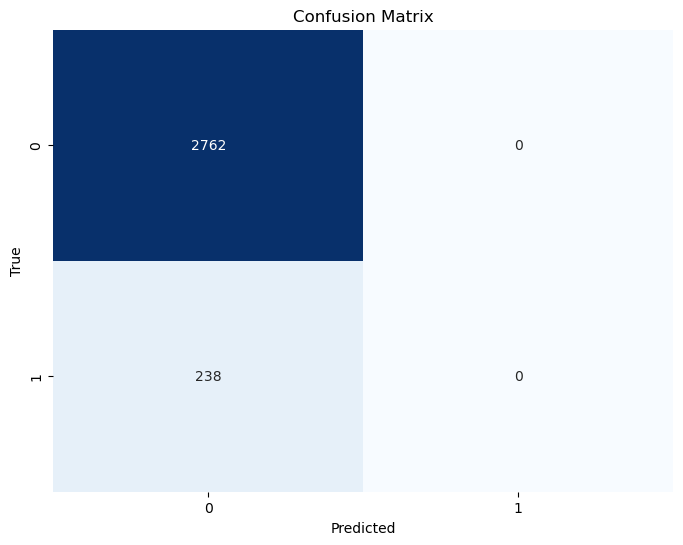

In [ ]:
# plottin confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(numpy_target_labels, numpy_predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8476271111111111
Recall: 0.9206666666666666
F1-score: 0.882638435728335


/home/benjamin.lambright/.conda/envs/ugrip/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Transformer model using keras (tensorflow)

# Input(shape=(n_frames, num_features + 1))
# query_input = Input(shape=(n_frames, num_features + 1))
# value_input = Input(shape=(n_frames, num_features + 1))
# token_embedding = Embedding(input_dim=1000, output_dim=64)
# query_embedding = token_embedding(query_input)
# value_embedding = token_embedding(value_input)
# query_seq_encoding = Conv2D(query_embedding)
# value_seq_encoding = Conv2D(value_embedding)
# attention_layer = Attention()([query_seq_encoding, value_seq_encoding])
# output_layer = TimeDistributed(Dense(2, activation='sigmoid'))(BLSTM_2_layer)
# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# query_input = keras.layers.Input(shape=(n_frames, num_features + 1))
# value_input = keras.layers.Input(shape=(n_frames, num_features + 1))
# # these inputs won't work for the embedding unless if we reshape them, so I added that
# query_input_reshaped = keras.layers.Reshape((n_frames * (num_features + 1),))(query_input)
# value_input_reshaped = keras.layers.Reshape((n_frames * (num_features + 1),))(value_input)
# # plugging into embeddings
# token_embedding = keras.layers.Embedding(input_dim=1000, output_dim=64)
# query_embedding = token_embedding(query_input_reshaped)
# value_embedding = token_embedding(value_input_reshaped)
# # do a CNN layer
# cnn_layer = keras.layers.Conv1D(filters=100, kernel_size=4, padding='same')  # using padding 
# query_seq_encoding = cnn_layer(query_embedding)
# value_seq_encoding = cnn_layer(value_embedding)
# # plug into attention model, ensure that shape remains the same
# qv_attention_seq = keras.layers.Attention()([query_seq_encoding, value_seq_encoding])
# query_encoding = keras.layers.GlobalAveragePooling1D(keepdims=True)(query_seq_encoding)
# qv_attention = keras.layers.GlobalAveragePooling1D(keepdims=True)(qv_attention_seq)
# input_layer = keras.layers.Concatenate()([query_encoding, qv_attention])
# # linear layers
# dense_layer1 = keras.layers.Dense(units=128, activation='relu')(input_layer)
# dense_layer2 = keras.layers.Dense(units=64, activation='relu')(dense_layer1)
# # output
# output_layer = keras.layers.Dense(units=300*2, activation='softmax')(dense_layer2)  # maybe change the activation cause we don't need softmax for binary classification?
# output_layer_reshaped = keras.layers.Reshape((300, 2))(output_layer)
# model = keras.Model(inputs=[query_input, value_input], outputs=output_layer_reshaped)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(x=[X_train_reshaped, X_train_reshaped], y=y_train_reshaped, validation_data=([X_test_reshaped, X_test_reshaped], y_test_reshaped), epochs=25, batch_size=64)

In [ ]:
import matplotlib.pyplot as plt 

def plot_loss(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history['loss'], c ="darkblue")
    # plt.plot(history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()


def plot_accuracy(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history['accuracy'], c ="darkblue")
    # plt.plot(history['val_accuracy'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha = 0.2)
    plt.show()

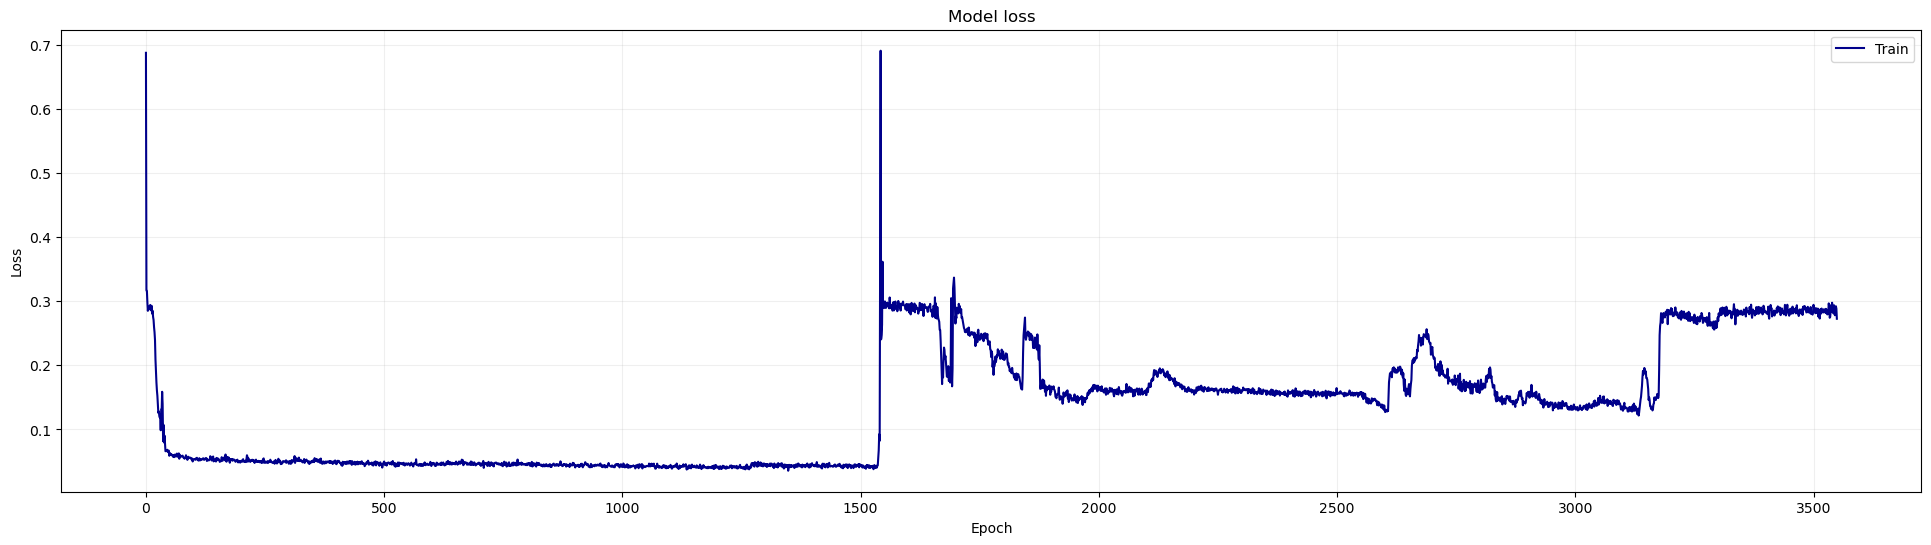

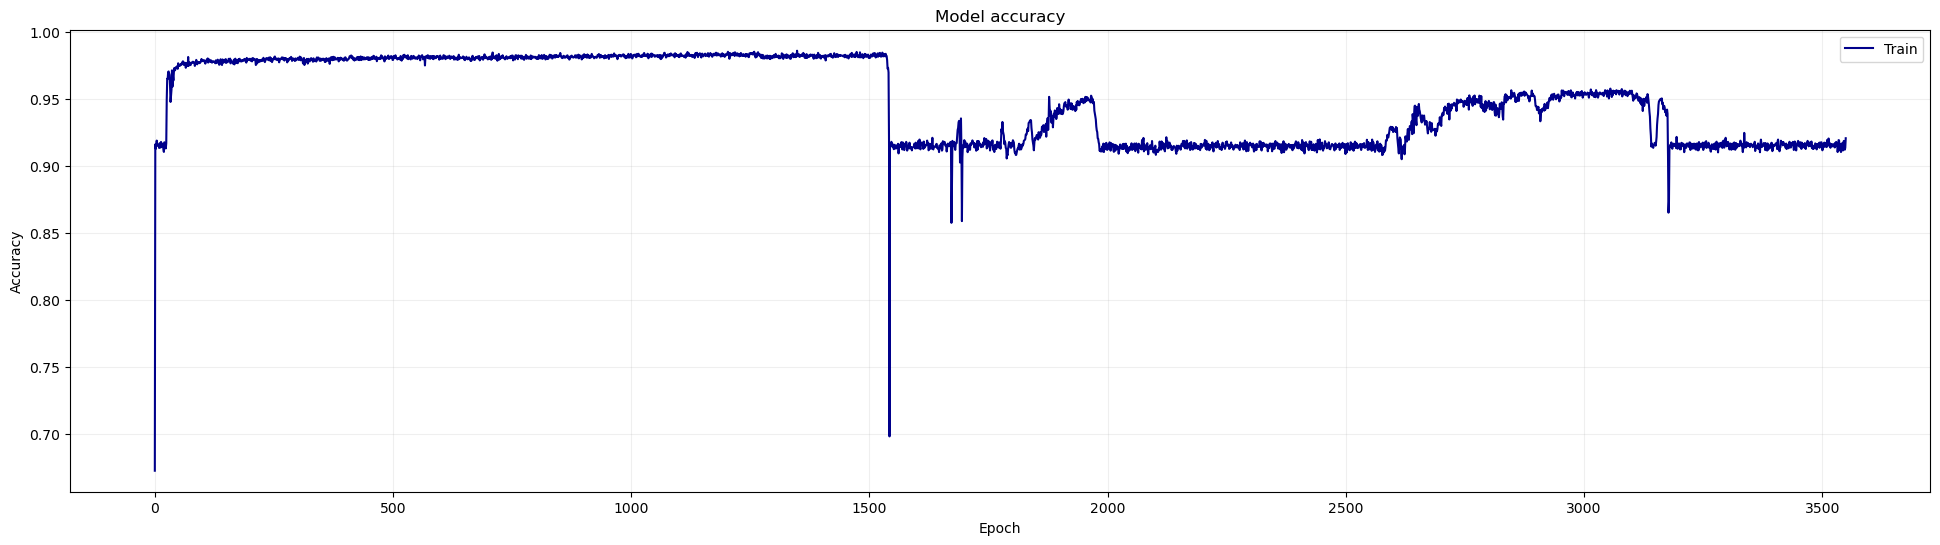

In [ ]:
plot_loss(history)
plot_accuracy(history)

In [ ]:
# figure out how to plot the loss and accuracy over time

# plot_loss(history)
# plot_accuracy(history)

In [ ]:
annotation_file = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/master_annotations/8c920fd0-fa9f-4926-bcac-074767dcbfcd-1436850948195-1.7-m-04-hu.wav.TextGrid"
audio_file = "/home/benjamin.lambright/Desktop/ugrip/Datasets_to_sort/no_subdirectories/8c920fd0-fa9f-4926-bcac-074767dcbfcd-1436850948195-1.7-m-04-hu.wav"

# Load samples:
input_signal, fs = librosa.load(audio_file)


# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract features:
features_fbank_valid, feature_energy_valid  = python_speech_features.base.fbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step, 
                                                                                nfilt=num_features, nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef, 
                                                                                winfunc=window_function)

# Logfbank and log energy:
features_logfbank_valid = np.log(features_fbank_valid)
feature_logenergy_valid = np.log(feature_energy_valid)

# Merge logfbank and log energy:
features_valid = np.hstack((feature_logenergy_valid.reshape(feature_logenergy_valid.shape[0], 1), features_logfbank_valid))

# Reshape labels for each group of features:
markers_of_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(markers_of_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(markers_of_frames_truth[j], axis=0) > markers_of_frames_truth.shape[0] / 2 else 0 
                                   for j in range(markers_of_frames_truth.shape[0])])

# Check indices of features and labels:
restrictive_index = np.min([features_valid.shape[0], markers_of_frames_truth.shape[0]], axis=0)
features_valid_tmp = features_valid[:restrictive_index]
marker_per_frame_truth_tmp = marker_per_frame_truth[:restrictive_index]

In [ ]:
# Split label and features:
X_valid = features_valid_tmp;
y_truth = marker_per_frame_truth_tmp

# Scaling:
X_valid = scaler.transform(X_valid)

# Reshape datasets to 1 x 300 x num_features:
if X_valid.shape[0] < n_frames:
    added_frames = np.zeros((n_frames - X_valid.shape[0], X_valid.shape[1]))
    add_labels = np.zeros(n_frames - X_valid.shape[0])
    X_valid = np.vstack((X_valid, added_frames))
    y_truth = np.hstack((y_truth, add_labels))
X_valid_reshaped = X_valid[:int(X_valid.shape[0] / n_frames) * n_frames]
X_valid_reshaped = X_valid_reshaped.reshape(int(X_valid_reshaped.shape[0] / n_frames), n_frames, X_valid_reshaped.shape[1])

In [ ]:
# convert it to numpy array
valid_input = torch.tensor(X_valid_reshaped, dtype=torch.float).to(device)

# predict
model.eval()
with torch.no_grad():
    prediction = model.forward(valid_input)

predicted_label = np.zeros(prediction.shape[0] * prediction.shape[1])
predicted_proba = np.zeros(prediction.shape[0] * prediction.shape[1])
ind = 0
for i in range(prediction.shape[0]):
    for j in range(prediction.shape[1]):
        if prediction[i][j][0] >= prediction[i][j][1]:
            predicted_label[ind] = 0
            predicted_proba[ind] = prediction[i][j][0]
        else:
            predicted_label[ind] = 1
            predicted_proba[ind] = prediction[i][j][1]
        ind = ind + 1
        
predicted_label

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label.shape[0]):
    label_timeseries[begin:end] = predicted_label[i]
    begin = begin + shift_step
    end = end + shift_step

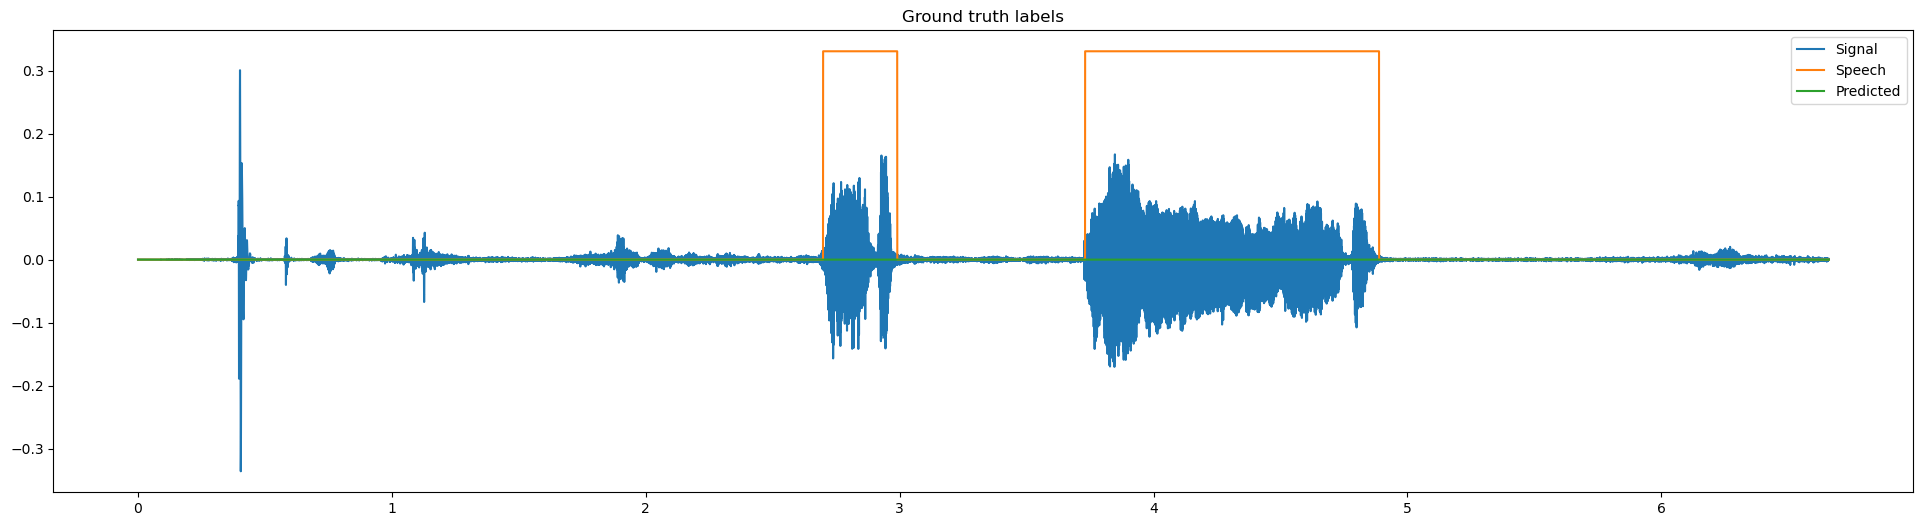

In [ ]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()

In [ ]:
import metrics

# predicted_labels = label_timeseries[:-1]

segment_metrics = metrics.segment_metrics(truth_labels, label_timeseries, 100)
(segment_metrics["true_positive"], segment_metrics["false_positive"], segment_metrics["false_negative"])

ZeroDivisionError: division by zero

In [ ]:
len(truth_labels), len(label_timeseries)

(146853, 146853)

In [ ]:
segment_metrics["f_score"]

0.7457627118644068

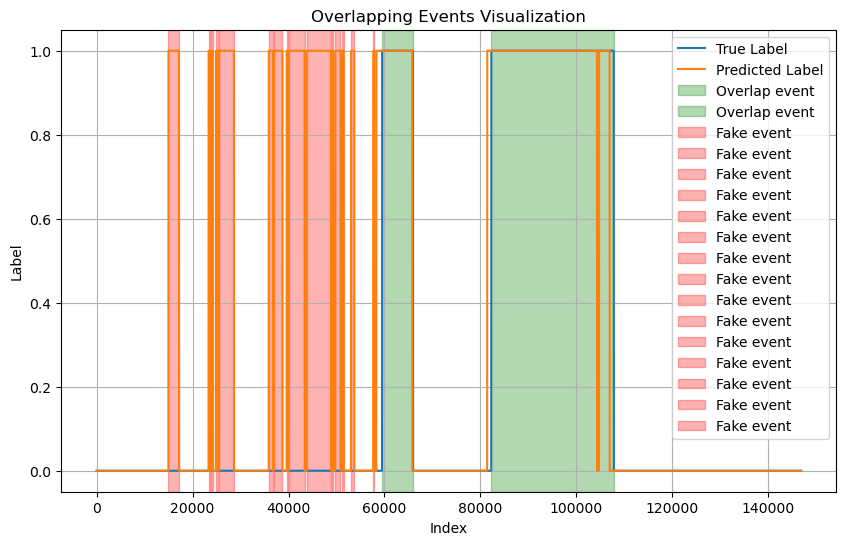

In [ ]:
event_metrics = metrics.event_metrics(truth_labels, label_timeseries, tolerance=2000, overlap_threshold=0.75)
metrics.event_visualization(truth_labels, label_timeseries, event_metrics['counted_events'], event_metrics['fake_events'], event_metrics['undetected_events'])

In [ ]:
(event_metrics["true_positive"], event_metrics["false_positive"], event_metrics["false_negative"])

(2, 15, 0)

In [ ]:
event_metrics["f_score"]

0.21052631578947367